# Import dependencies

In [1]:
import pandas as pd
import ast
import re
import umap
import numpy as np
from dotenv import load_dotenv
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


load_dotenv()

/Users/conor/Documents/CISC500- Individual Thesis/conor-repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Read and clean data

In [ ]:


def safe_literal_eval(val):
    if pd.isna(val):  
        return []     
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [] 
    
def clean_text(text):
    # quotes
    text = re.sub(r"(?m)^\s*>.*(?:\r?\n|$)", "", text)

    # links and code
    # should we consider using LLM to generate short summary of the code snippets so we don't lose any context it could provide
    # or could use regex to detect patterns in the code and classify them e.g. detecting import statements, function definitions, or added/removed lines.
    pattern = r"```.*?```|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    cleaned_text = re.sub(pattern, "", text, flags=re.DOTALL)

    # keep only alphanumeric characters and punctuation
    cleaned_text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"(){}\[\]\-]", " ", cleaned_text)

    # remove extra spaces
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text
    
def preprocess_text(comments_sequence):
    all_threads = []
    for comment_thread in comments_sequence:
        main_comment = comment_thread['comment']['body']
        replies = [reply['body'] for reply in comment_thread['replies']]
        thread = main_comment + "\n" + "\n".join(replies)
        
        thread = clean_text(thread)
        if thread != "":
            all_threads.append(thread)

    return all_threads

df= pd.read_csv('../data/pull_requests_filtered_raw.csv')
df['comments'] = df['comments'].apply(safe_literal_eval)

df['review_threads'] = df['comments'].apply(lambda comments: [item for item in comments if item['type'] == 'review'] if type(comments) is not float else comments)
df = df[df['review_threads'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df['processed_review_threads'] = df['review_threads'].apply(preprocess_text)

threads = sum(df['processed_review_threads'].tolist(), [])


# Cluster Using Bertopic

In [3]:
# https://bertopic.readthedocs.io/en/latest/
# https://maartengr.github.io/BERTopic/api/representation/keybert.html
# https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html

# used to fine-tune topic representations
representation_model = KeyBERTInspired()
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15, n_components=5, random_state=42)     # fix topics across runs by setting random_state; otherwise UMAP is stochastic

# using pre-calculated embeddings
# topic_model = BERTopic(min_topic_size=20)
# topics, probs = topic_model.fit_transform(threads, thread_embeddings)

# using KeyBERTInspired to generate embeddings
topic_model = BERTopic(representation_model=representation_model, vectorizer_model=vectorizer_model, umap_model=umap_model, min_topic_size=20)
topics, probs = topic_model.fit_transform(threads)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitl

## General Topic Info

In [4]:
# set Pandas formatting for printing
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [ ]:
print(topic_model.get_topic_info())

# topic_model.visualize_barchart()

## Classifying comments from codeowner and non-codeowner PRs

In [4]:
comments_cluster = [63, 126, 86, 177, 55, 172, 156, 185, 96]
typing_casting_cluster = [139, 36, 123, 107, 53, 105, 87]        
redudant_code_files_cluster = [85, 153, 113, 167, 15, 106, 181, 148, 47, 138]
fixed_cluster = [132, 180]      # 'Fixed in ...'
code_style_cluster = [128, 176, 130, 110, 52, 91, 19, 98, 30, 103, 109, 13, 42, 70, 89, 127, 114, 99, 170, 79, 144, 166, 168, 71, 76, 21, 90, 59]       # indentation, if statement styles, moving checks, single-use variables, renaming, using const, linting
thanks_acknowledgements_cluster = [39, 46]
process_cluster = [162, 12, 45, 73, 56]      # dependency bumps in different PR, "do in another PR", "revert change/not needed", rebasing, limit to one platform per PR
misc_cluster = [152, 175, 82, 173, 97, 74, 152, 37]  # "same here", "done", "same as above" etc
imports_cluster = [38, 75]
config_entries_cluster = [145, 149, 77, 83, 101, 140, 188, 187, 17, 9, 88, 163, 44, 35]     # including move away from YAML
async_eventloop_cluster = [81, 48, 64, 125, 34]
error_handling_cluster = [104, 72, 151, 40, 24, 150, 124]
logging_cluster = [122, 60, 31, 131]
measurements_cluster = [29, 129, 157]    # unit of measurements, sensor measurements, power/watts/energy
icon_name_device_translations_cluster = [14, 67, 4]
time_timezone_dates_duration_cluster = [16, 95]
classes_inheritance_attributes_cluster = [23, 171, 142]
dictionary_dictkeys_cluster = [43, 3, 158]
update_coordinator_interval_polling_cluster = [18, 116, 93, 6]
testing_cluster = [119, 174, 32, 51, 11, 160, 94, 178, 111, 102, 182]
external_library_cluster = [136, 133, 57]   # this is also present partially in other clusters
unique_ids_cluster = [65, 33]
assigning_attributes_cluster = [143, 27, 92, 80, 179]
entity_cluster = [1, 164, 137, 118]
protocols_cluster = [165, 66, 115, 134, 146, 61, 68]
device_cluster = [25, 49]
validation_schemas_cluster = [155, 78, 28]
blueprints_cluster = [135]      # use a select selector for blueprint
state_cluster = [7, 169, 100]
domain_cluster = [141]
service_cluster = [54]
authentication_cluster = [2]
voice_assistant_conversation_cluster = [154, 159]
questions_cluster = [121]
other_cluster = [186, 120, 161, 147, 117, 20, 41, 184, 147, 183, *fixed_cluster, *misc_cluster, *blueprints_cluster, *domain_cluster]

# remaining topics included in other:
# 183 = Tuya (brand) devices
# 184 = caching, cache decorator
# 186 = comments about tilt, cover, ... of blinds- basically all from https://github.com/home-assistant/core/pull/48625
# 120 = random number string noise
# 147 = minValue, maxValue, min max
# 161 = mixins
# 117 = general "update" stuff
# 20 = bunch of mixed things involving Home Assistant
# 41 = mixed bag of integration related items

# remaining topics in own cluster
# 8 = light, rbg, brightness
# 5 = temperature, hvac, fans, climate
# 10 = defaults
# 0 = sensor entities, sensors
# 112 = humidity, humidifier integration
# 62 = locks, alarms integrations
# 84 = images, cameras
# 22 = hass object, hass.data etc
# 26 = media players
# 58 = notifications, notification integration
# 69 = buttons, button integration

topic_to_cluster = {}

# Map each topic ID to its cluster name
topic_to_cluster.update({topic_id: "Typing & Casting" for topic_id in typing_casting_cluster})
topic_to_cluster.update({topic_id: "Redundant Code & Comments" for topic_id in [*redudant_code_files_cluster, *comments_cluster]})
topic_to_cluster.update({topic_id: "Code Style" for topic_id in code_style_cluster})
topic_to_cluster.update({topic_id: "Thanks & Acknowledgements" for topic_id in thanks_acknowledgements_cluster})
topic_to_cluster.update({topic_id: "HA Guidelines" for topic_id in process_cluster})
topic_to_cluster.update({topic_id: "Imports" for topic_id in imports_cluster})
topic_to_cluster.update({topic_id: "Config Entries" for topic_id in config_entries_cluster})
topic_to_cluster.update({topic_id: "Async & Eventloop" for topic_id in async_eventloop_cluster})
topic_to_cluster.update({topic_id: "Error Handling" for topic_id in error_handling_cluster})
topic_to_cluster.update({topic_id: "Logging" for topic_id in logging_cluster})
topic_to_cluster.update({topic_id: "Measurement & Units" for topic_id in measurements_cluster})
topic_to_cluster.update({topic_id: "String & Icon Translations" for topic_id in icon_name_device_translations_cluster})
topic_to_cluster.update({topic_id: "Timing & Timezones" for topic_id in time_timezone_dates_duration_cluster})
topic_to_cluster.update({topic_id: "Classes & Inheritance" for topic_id in classes_inheritance_attributes_cluster})
topic_to_cluster.update({topic_id: "Dictionary Operations" for topic_id in dictionary_dictkeys_cluster})
topic_to_cluster.update({topic_id: "Data Coordinators" for topic_id in update_coordinator_interval_polling_cluster})
topic_to_cluster.update({topic_id: "Testing" for topic_id in testing_cluster})
topic_to_cluster.update({topic_id: "Device Library" for topic_id in external_library_cluster})
topic_to_cluster.update({topic_id: "IDs" for topic_id in unique_ids_cluster})
topic_to_cluster.update({topic_id: "Attribute Assignment" for topic_id in assigning_attributes_cluster})
topic_to_cluster.update({topic_id: "Communication Protocols" for topic_id in protocols_cluster})
topic_to_cluster.update({topic_id: "Devices" for topic_id in device_cluster})
topic_to_cluster.update({topic_id: "Schemas & Validation" for topic_id in validation_schemas_cluster})
topic_to_cluster.update({topic_id: "State Management" for topic_id in state_cluster})
topic_to_cluster.update({topic_id: "Services" for topic_id in service_cluster})
topic_to_cluster.update({topic_id: "Authentication" for topic_id in authentication_cluster})
topic_to_cluster.update({topic_id: "Voice Assistant" for topic_id in voice_assistant_conversation_cluster})
topic_to_cluster.update({topic_id: "Questions" for topic_id in questions_cluster})
topic_to_cluster[8] = "Light"
topic_to_cluster[5] = "Climate & Fan"
topic_to_cluster[0] = "Sensor"
topic_to_cluster[112] = "Humidifier"
topic_to_cluster[84] = "Camera & Image"
topic_to_cluster[26] = "Media Player"
topic_to_cluster[58] = "Notification"
topic_to_cluster[69] = "Button"
topic_to_cluster[62] = "Lock & Alarm"

# remaining topics in own cluster
# 8 = light, rbg, brightness
# 5 = temperature, hvac, fans, climate
# 10 = defaults
# 0 = sensor entities, sensors
# 112 = humidity, humidifier integration
# 62 = locks, alarms integrations
# 84 = images, cameras
# 22 = hass object, hass.data etc
# 26 = media players
# 58 = notifications, notification integration
# 69 = buttons, button integration




In [ ]:
with open('../data/CODEOWNERS.txt') as file:
    lines = file.readlines()
    codeowners = [line.strip() for line in lines if line.strip() and not line.startswith('#')]

def is_any_code_owner(row):
    author = row["Author"]

    return any([str(author) in line for line in lines])

df["Author Is Codeowner"] = df.apply(is_any_code_owner, axis=1)     # axis=1 applies function to each row

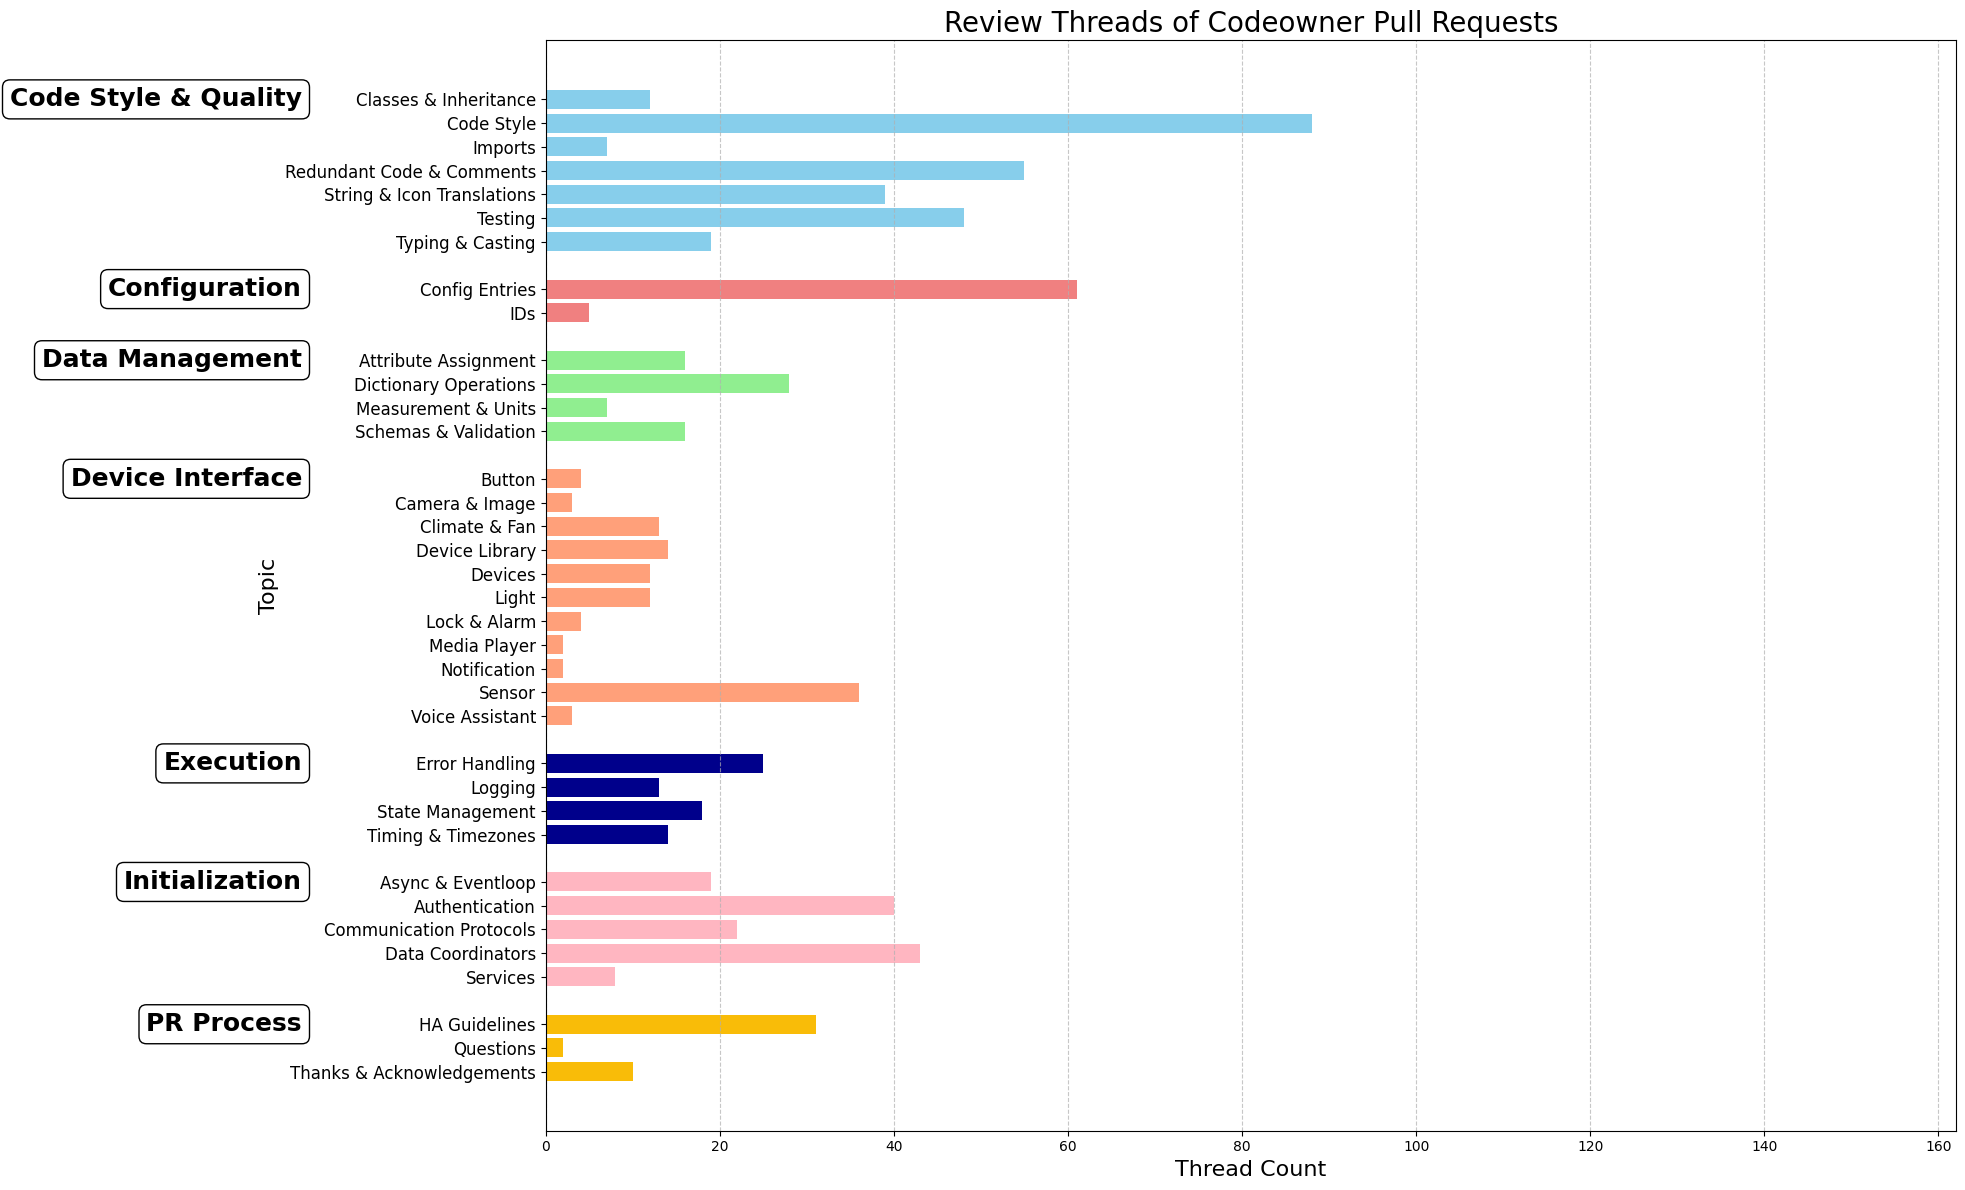

In [ ]:

# "Codeowner" or "Non-Codeowner"
type = "Codeowner"

df_codeowner = df[df["Author Is Codeowner"]]
codeowner_sampled = df_codeowner.sample(n=400, random_state=22)     # random_state=22 is good
codeowner_threads = sum(codeowner_sampled['processed_review_threads'].tolist(), [])
codeowner_topics, probs = topic_model.transform(codeowner_threads)

df_non_codeowner = df[~df["Author Is Codeowner"]]
non_codeowner_sampled = df_non_codeowner.sample(n=400, random_state=22) 
non_codeowner_threads = sum(non_codeowner_sampled['processed_review_threads'].tolist(), [])
non_codeowner_topics, probs = topic_model.transform(non_codeowner_threads)

codeowner_results_df = pd.DataFrame({
    'Document': codeowner_threads,
    'Topic': codeowner_topics,
})

non_codeowner_results_df = pd.DataFrame({
    'Document': non_codeowner_threads,
    'Topic': non_codeowner_topics,
})

# --------------
# CHANGE HERE DEPENDING ON IF DOING COMPLEX OR NON_COMPLEX
unique_topics, counts = np.unique(codeowner_topics if type == "Codeowner" else non_codeowner_topics, return_counts=True)

topic_counts = pd.DataFrame({
    'Topic': unique_topics,
    'Count': counts
})

# Apply the mapping to create a new 'Cluster' column
topic_counts['Cluster'] = topic_counts['Topic'].map(
    lambda x: topic_to_cluster.get(x, "Other")
)

# Group by the cluster and sum the counts
cluster_counts = topic_counts.groupby('Cluster')['Count'].sum().reset_index()
cluster_counts = cluster_counts[cluster_counts['Cluster'] != "Other"]

# Define the high-level grouping
topic_mapping = {
    # "Code Style & Quality": "Code Style & Quality",
    "Typing & Casting": "Code Style & Quality",
    "Imports": "Code Style & Quality",
    "Testing": "Code Style & Quality",
    "Redundant Code & Comments": "Code Style & Quality",
    "Code Style": "Code Style & Quality",
    "String & Icon Translations": "Code Style & Quality",
    "Classes & Inheritance": "Code Style & Quality",
    
    # "Initialization": "Initialization",
    "Communication Protocols": "Initialization",
    "Async & Eventloop": "Initialization",
    "Services": "Initialization",
    "Data Coordinators": "Initialization",
    "Authentication": "Initialization",
    
    # "Configuration": "Configuration",
    "IDs": "Configuration",
    "Config Entries": "Configuration",
    
    # "Device Interface": "Device Interface",
    "Device Library": "Device Interface",
    "Devices": "Device Interface",
    "Sensor": "Device Interface",
    "Light": "Device Interface",
    "Climate & Fan": "Device Interface",
    "Lock & Alarm": "Device Interface",
    "Media Player": "Device Interface",
    "Button": "Device Interface",
    "Camera & Image": "Device Interface",
    "Notification": "Device Interface",
    "Humidifier": "Device Interface",
    "Voice Assistant": "Device Interface",
    
    # "PR Process": "PR Process",
    "HA Guidelines": "PR Process",
    "Thanks & Acknowledgements": "PR Process",
    "Questions": "PR Process",
    
    # "Data Management": "Data Management",
    "Attribute Assignment": "Data Management",
    "Dictionary Operations": "Data Management",
    "Schemas & Validation": "Data Management",
    "Measurement & Units": "Data Management",
    
    # "Execution": "Execution",
    "Error Handling": "Execution",
    "State Management": "Execution",
    "Logging": "Execution",
    "Timing & Timezones": "Execution",
}

color_palette = {
    "Code Style & Quality": "skyblue",
    "Initialization": "lightpink",
    "Configuration": "lightcoral",
    "Device Interface": "lightsalmon",
    "PR Process": "xkcd:golden rod",
    "Data Management": "lightgreen",
    "Execution": "darkblue",
}

# Map to high-level category
cluster_counts["Higher Level Category"] = cluster_counts["Cluster"].map(topic_mapping)

# Sort by high-level category and then by topic
cluster_counts = cluster_counts.sort_values(by=["Higher Level Category", "Cluster"])

# Create a new spaced dataset
spaced_topics = []
spaced_counts = []
y_positions = []
category_positions = {}

y_index = 0  # Position tracker
previous_category = None

# Create a list of colors for each bar based on its category
bar_colors = []

for _, row in cluster_counts.iterrows():
    category = row["Higher Level Category"]
    bar_colors.append(color_palette.get(category, "gray"))

    # Add a space if changing categories
    if previous_category and previous_category != category:
        y_index += 1  # Extra space

    # Store category label position (once per category)
    if category not in category_positions:
        category_positions[category] = y_index

    # Add topic data
    spaced_topics.append(row["Cluster"])
    spaced_counts.append(row["Count"])
    y_positions.append(y_index)

    y_index += 1  # Move index

    previous_category = category

# Convert y_positions to numpy array
y_positions = np.array(y_positions)

# Create figure
fig, ax = plt.subplots(figsize=(20, 12))

# Plot bars
# ax.barh(y_positions, spaced_counts, color="skyblue")
ax.barh(y_positions, spaced_counts, color=bar_colors)

# Set y-axis labels
ax.set_yticks(y_positions)
ax.set_yticklabels(spaced_topics, fontsize=12)

# Add category labels as separators
# for category, pos in category_positions.items():
#     ax.text(-max(spaced_counts) * 0.15, pos, category, ha="right", va="center", 
#             fontsize=12, fontweight="bold", color="black", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
for category, pos in category_positions.items():
    ax.text(-28, pos, category, ha="right", va="center", 
            fontsize=18, fontweight="bold", color="black", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Grid for readability
ax.xaxis.grid(True, linestyle="--", alpha=0.7)

# Improve layout
ax.set_xlim(xmax=162)       # CHANGE THIS BASED ON WHAT MAX VALUES ARE AROUND FOR COMPLEX OR NON-COMPLEX
ax.set_xlabel("Thread Count", fontsize=16)
ax.set_ylabel("Topic", fontsize=16)
ax.set_title(f"Review Threads of {type} Pull Requests", fontsize=20)
ax.invert_yaxis()  # Highest value at the top

plt.tight_layout()
# plt.savefig(f'../plot-images/topics_{'codeowners' if type == "Codeowner" else 'non_codeowner'}.png')
plt.show()
